# Computational Linear Algebra
$\verb|BLAS|$ <b>B</b>asic <b>L</b>inear <b>A</b>lgebra <b>S</b>ubprograms and one common implementation, $\verb|LAPACK|$ <b>L</b>inear <b>A</b>lgebra <b>Pack</b>age are standard software libraries for numerical computation, and are used in Python's scikit-learn, TensorFlow, PyTorch, NumPy and SciPy, as well as R, C++'s Armadillo, and C.

# Singular Value Decomposition
Consider an $m\times n$ matrix 
$$\mathbf{A} = \begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & & \vdots \\
a_{m1} & a_{m2} & \cdots & a_{mn}
\end{bmatrix}$$
and an $n \times 1$ vector $$\vec{x} = \begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n} \\
\end{bmatrix}$$
When we perform the multiplication $\mathbf{A}\vec{x}$, the result is a rotation of $\vec{x}$ onto a space of $m$ or fewer dimensions, and a scaling.
![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Singular_value_decomposition.gif)
This means this is the only thing a linear transformation does. It rotates, scales, and then rotates again. We can decompose any matrix into 3 matrices representing each of these actions (as guaranteed by the SVD theorem).
$$\mathbf{A} = \mathbf{U\Sigma V^*}$$
Where $\mathbf{U}$ is a rotation, $\mathbf{\Sigma}$ is a scaling, and $\mathbf{V^*}$ is the final rotation. These matrices have special structures: 
![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/220px-Singular_value_decomposition_visualisation.svg.png)
In particular, the matrix $\mathbf{\Sigma}$ can be thought of as describing the dimensionality of the data. The truncated sum of the square of the decreasing diagonal elements describes the data variance captured by a rank $r$ truncation, which is a dimensionality reduction from $n$ to $r$.

In practice, most datasets are low-dimensional, meaning they are well approximated by these rank reductions.

# Principal Component Analysis
How can we visualize or consolidate high dimensional spaces into lower dimensions in a way that preserves some notions of distance? What we want to do is not unlike transforming a country into a map, or a building into its floorplans. It is not only a natural way to compress data, but also a natural way to visualize it.
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/1200px-GaussianScatterPCA.svg.png " width="650" height="650" />
The idea behind PCA is the question: have we considered the ideal coordinate space for the problem? When humanity shifted from a geocentric to a heliocentric model, it involved an enormous shift in coordinates, but all planetary motion suddenly made sense.
## Relationship with SVD
If we decompose a matrix whose columns have mean 0 and variance 1 with the SVD, the principal components are given by $\mathbf{T}=\mathbf{U\Sigma}$ Where $\mathbf{T}$ are called the principal component scores. If there are $n$ singular values, if we take only the first $r$ to be non-zero this is called the rank-$r$ truncation of the matrix.

### Example 1: Image Compression


In [1]:
from sklearn import datasets
mnist_data = datasets.fetch_openml('mnist_784', version=1)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def extract_image(data, i, dim=-1):
    extracted = []
    for j in i:
        extracted.append(np.reshape(data[j, :], dim))
    
    return extracted

def show_images(data, show):
    images = extract_image(data, show, (28, 28))
    fig, axes = plt.subplots(1, len(show), figsize=(200/len(show), 10))
    for i, ax in enumerate(axes):
        ax.matshow(-images[i], cmap=plt.cm.gray)
        ax.set_xticks(())
        ax.set_yticks(())
        
show_images(mnist_data.data, range(10))

In [3]:
import numpy as np
def pca(data, plot_variance=True, variance_captured=np.array([.90, .95, .99])):
    # The principal component analysis requires that data is demeaned and normalized
    data = np.copy(data)
    mean = np.mean(data, axis=0)
    M, N = data.shape
    std = np.sqrt(M-1)
    data -= mean
    data /= std
    
    # This is the singular value decomposition, which gives the singular values s
    u, s, v = np.linalg.svd(data, full_matrices=False)
    if plot_variance:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        axes[0].plot(s, linestyle=':')

        # The variance is s^2, so we can see how much variance is captured with each dimension
        energy = np.power(s, 2)
        energy = energy / np.sum(energy)
        energy_up_to = np.cumsum(energy)
        axes[1].plot(energy_up_to)

        axes[1].hlines(variance_captured, 0, len(energy_up_to), linestyles='dashed')
        dims = np.tile(energy_up_to, (len(variance_captured), 1))>np.tile(variance_captured, (len(energy_up_to), 1)).T
        dims = np.argmax(dims, axis=1)
        print('Dimensions to capture:')
        for dim, var in zip(dims, variance_captured):
            print('{0}% energy: {1} (compression to {2:.2f}%)'.format(var*100, dim, dim/N*100))
        axes[1].scatter(dims, variance_captured, marker='s', s=75, c='red')
    
    # This computes the principle components.
    # Alternatively, this can be computed as X*V if V is full.
    return u * s, [u,s,v], dims, mean, std

Dimensions to capture:
90.0% energy: 86 (compression to 10.97%)
95.0% energy: 153 (compression to 19.52%)
99.0% energy: 330 (compression to 42.09%)
99.9% energy: 485 (compression to 61.86%)
99.99% energy: 578 (compression to 73.72%)


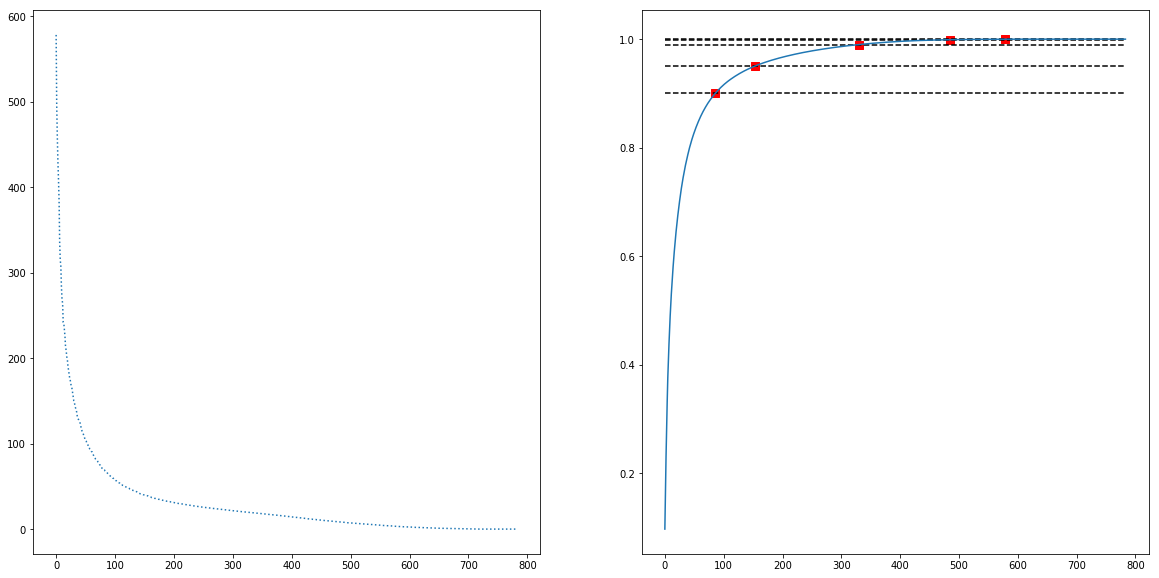

In [4]:
PC, svd, dims, mu, sd = pca(mnist_data.data, variance_captured=np.array([.90, .95, .99, .999, .9999]))

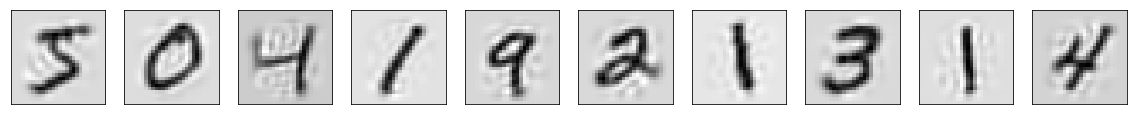

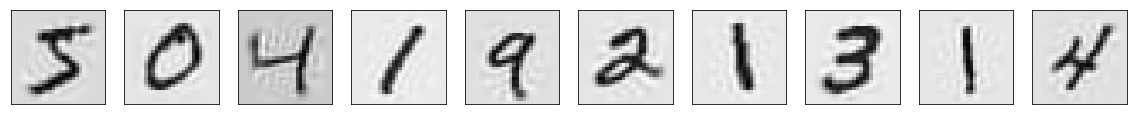

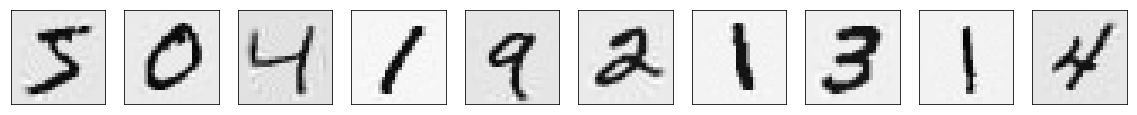

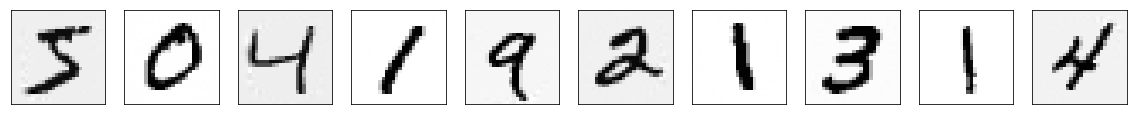

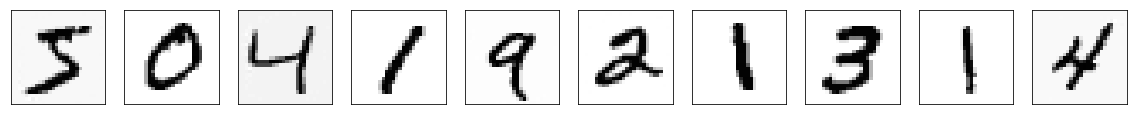

In [5]:
def compress(data, SVD, r, m, std):
    u, s, v = SVD
    
    for trunc in r:
        s_r = np.copy(s)
        s_r[(trunc+1):] = 0
        
        X_r = std * (u * s_r) @ v + m
        #X_r *= s
        #X_r += m
        
        show_images(X_r, range(10)) #(u * s) @ v + m, range(10))#X_r.astype(np.int64), range(10))
        
compress(mnist_data.data, svd, dims, mu, sd)
#print(mu)

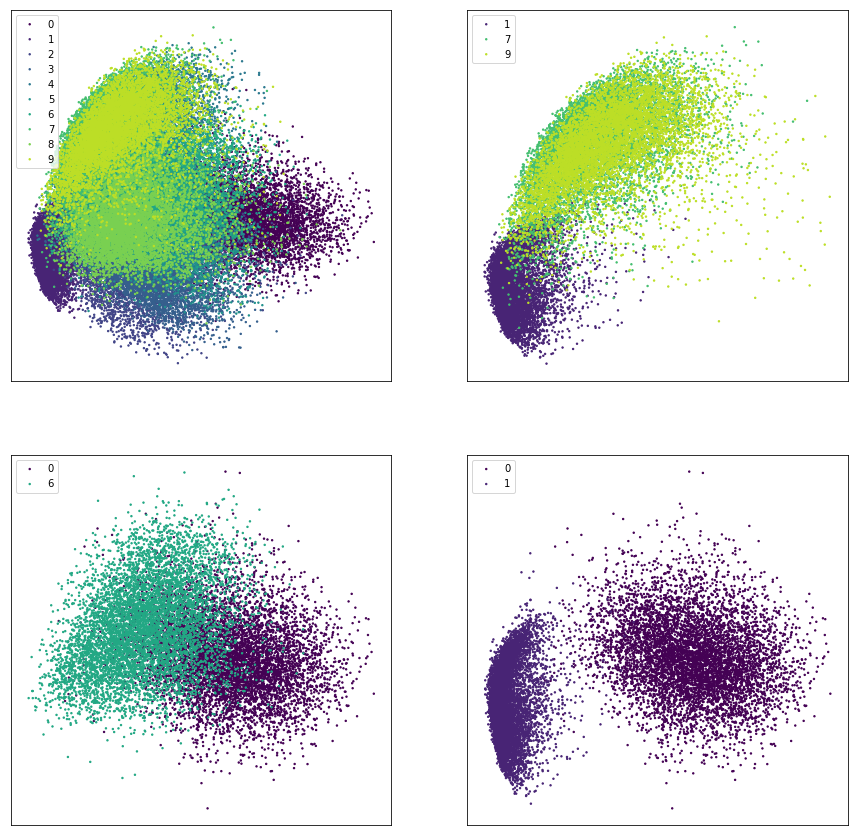

In [6]:
def plot_class_pca(pca, target, class_list, figure, axis, dim=2):
    viridis = plt.get_cmap('viridis')
    plotted = np.zeros_like(target).astype(np.bool)
    if dim==2:
        for i in class_list:
            kind = target == i
            axis.scatter(pca[kind, 0], pca[kind, 1], s=2, alpha=.99, c=viridis(i*np.ones_like(pca[kind, 0])/10), label=str(i))
            plotted = kind | plotted
        
        axis.legend(loc='upper left')
        axis.set_xticks(())
        axis.set_yticks(())
        
        return pca[plotted, 0:dim], target[plotted], plotted
        
    elif dim==3:
        pca = pca.loc[np.in1d(pca['target'].to_numpy(), class_list), :]
        
        fig = px.scatter_3d(pca, x='PC1', y='PC2', z='PC3', color='target', size_max=10)
        fig.show()
        
        return pca
        
    else:
        print('dim should be 2 or 3')
        
        
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
target = mnist_data.target.astype(np.int64)

plot_class_pca(PC, target, np.arange(10), fig, axes[0][0])
plot_class_pca(PC, target, np.array([0,6]), fig, axes[1][0])
plot_class_pca(PC, target, np.array([1,7,9]), fig, axes[0][1])
pc01, labels, which_plotted = plot_class_pca(PC, target, np.array([0, 1]), fig, axes[1][1])

In [7]:
!pip install plotly

In [8]:
import pandas as pd
import plotly.express as px
df_PC = pd.DataFrame(np.hstack([PC[:, 0:3], target.reshape(-1, 1).astype(str)]), columns=['PC1', 'PC2', 'PC3', 'target'])
df_PC_pltd=plot_class_pca(df_PC, target, np.array(['0', '1']), None, None, dim=3)
df_PC_pltd.head(10)

PC1                  PC2                  PC3 target
1     3.819335616045043  -1.0959672988449238   -2.177547292454552      0
3   -3.0122661485241635  -2.2958529252168125  -1.1169787998344496      1
6    -2.761002119505727  -0.6123196172752469   0.8959894069336545      1
8   -3.3055245511614277  -0.3186483417926177   0.4322147755366411      1
14  -3.2792621045102863  -0.8858738886547148   0.2853249778988764      1
21      3.9065204053895  -1.3273590743178336   -1.883772292436638      0
23   -3.047359425971971  -1.9954012177677398  -0.9901987585740215      1
24  -0.9983286180909468  -1.1030049061079692  -1.1358349022700878      1
34   2.3261104410691624  -0.9230725496689195    -2.37782943969408      0
37   3.5612869793690316  -0.9275275978306112  -3.2817207445370533      0

In [9]:
!pip install umap-learn

In [10]:
import umap
from sklearn.datasets import load_digits

digits = load_digits()

embedding = umap.UMAP().fit_transform(digits.data)

(array([[13.960962 ,  0.9475917],
        [-6.3294497,  4.0328183],
        [ 3.8596394, -3.9500477],
        ...,
        [-4.793038 ,  2.0291564],
        [-2.5583234, -1.7038603],
        [-4.4947057,  1.6102631]], dtype=float32),
 array([0, 1, 2, ..., 8, 9, 8]),
 array([ True,  True,  True, ...,  True,  True,  True]))

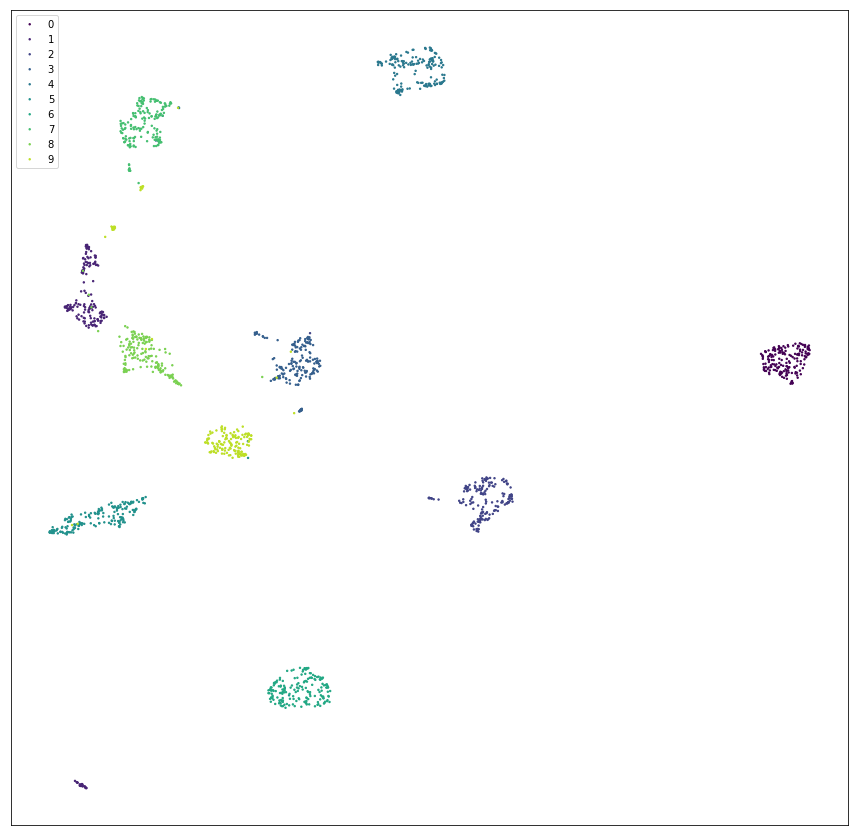

In [18]:
fig, axis = plt.subplots(figsize=(15, 15))
plot_class_pca(embedding, digits.target, range(10), fig, axis)